In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *

In [3]:
from bnbsl import *

In [4]:
SEASON = '21'
set_seed(int(SEASON))

## Data preparation

In [24]:
path = Path()
path_data = Path('data')

In [25]:
df = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])

In [26]:
div = ['E0', 'D1', 'SP1', 'I1', 'F1']
df = df[(df.Div.isin(div)) & (df.Season >= 11) & (df.Season <= 21)]

# Drop NA corner
df = df.dropna().reset_index(drop=True)

In [27]:
add_datepart(df, 'Date');

In [28]:
# Time-weighted
df['weight'] = np.exp(-(df.Elapsed.max() - df.Elapsed) / (3600*24*365) / df.Year.nunique())
df['weight'] = df['weight'] / df['weight'].mean()

In [29]:
procs = [Categorify, FillMissing, Normalize]

In [30]:
valid_idx = list(df.query('Season == 21').index)

In [31]:
splitter = IndexSplitter(valid_idx)
splits = splitter(range_of(df))

In [32]:
splits

((#17971) [0,1,2,3,4,5,6,7,8,9...],
 (#761) [3026,3027,3028,3029,3030,3031,3032,3033,3034,3035...])

In [33]:
y_names = ['HC', 'AC']
cat_names = ['Div', 'HomeTeam', 'AwayTeam']
cont_names = list(df.columns[df.columns.str.contains('Avg')])

In [34]:
y_block = RegressionBlock(n_out=2)

In [35]:
df.sample(10)

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,weight
234,D1,Bayern Munich,Augsburg,2.0,1.0,18.0,7.0,5.0,3.0,3.0,...,5,98,False,False,False,False,False,False,1.333757e+09,0.640746
13057,I1,Genoa,Atalanta,0.0,5.0,8.0,22.0,4.0,13.0,3.0,...,6,92,False,False,False,False,False,False,1.491091e+09,1.008462
10987,I1,Parma,Udinese,2.0,0.0,19.0,14.0,4.0,4.0,3.0,...,6,324,False,False,False,False,False,False,1.321747e+09,0.618942
16029,SP1,Espanol,Villarreal,1.0,1.0,11.0,9.0,4.0,5.0,6.0,...,6,313,False,False,False,False,False,False,1.415491e+09,0.810985
15643,SP1,Sevilla,Osasuna,2.0,1.0,23.0,7.0,4.0,3.0,9.0,...,6,300,False,False,False,False,False,False,1.382832e+09,0.738117
13271,I1,Genoa,Roma,1.0,1.0,9.0,14.0,4.0,4.0,1.0,...,6,330,False,False,False,False,False,False,1.511654e+09,1.070049
7415,F1,Rennes,Montpellier,0.0,2.0,21.0,8.0,7.0,2.0,3.0,...,0,128,False,False,False,False,False,False,1.336349e+09,0.645551
4459,E0,West Ham,Arsenal,1.0,2.0,14.0,21.0,4.0,7.0,7.0,...,6,362,False,False,False,False,False,False,1.419725e+09,0.820943
5635,E0,Tottenham,Everton,4.0,0.0,20.0,7.0,10.0,0.0,3.0,...,5,13,False,False,False,False,False,False,1.515802e+09,1.082918
975,D1,Mainz,Werder Bremen,1.0,2.0,21.0,9.0,3.0,7.0,8.0,...,5,305,False,True,False,False,False,False,1.414800e+09,0.809370


In [36]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [37]:
to.cat_names, to.cont_names

((#3) ['Div','HomeTeam','AwayTeam'],
 (#24) ['FTHGLast5Avg','HSLast5Avg','HSTLast5Avg','HCLast5Avg','FTAGLast5Avg','ASLast5Avg','ASTLast5Avg','ACLast5Avg','HomeFTGForLast5Avg','HomeSForLast5Avg'...])

In [38]:
display_df(to.xs.iloc[-2:])

,Div,HomeTeam,AwayTeam,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg
18730,5,157,53,0.341778,-0.411592,-0.140688,-0.654182,-0.317644,0.785416,-0.332169,1.712871,-0.230704,0.611437,0.582449,0.276490,-0.578316,-0.106247,-0.891300,0.595894,-0.959558,-0.165903,-0.263049,-0.07367,-0.910103,1.257481,0.925224,1.252397
18731,5,63,10,0.069972,-0.792623,-0.488743,-1.659029,-0.961025,1.158144,-0.053898,1.564129,0.072307,-0.711265,-0.194779,-1.666809,-1.171232,0.372519,-0.509131,0.459897,-1.290149,-0.165903,-1.226596,0.74467,-0.574295,-0.350946,-0.334311,-0.821945


### To other packages (e.g. Scikit-learn, LightGBM, XGBoost)

In [20]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor

In [21]:
X_train, y_train = to.train.xs, to.train.ys.values
X_test, y_test = to.valid.xs, to.valid.ys.values

In [22]:
X_train.shape, y_train.shape

((5377, 27), (5377, 2))

In [23]:
X_test.shape, y_test.shape

((712, 27), (712, 2))

## LightGBM

In [24]:
fit_params = {'feature_name':list(X_test.columns), 'categorical_feature':cat_names}

In [25]:
m_lgbm = MultiOutputRegressor(LGBMRegressor(objective='poisson', n_estimators=100, n_jobs=-1, reg_lambda=1.0))
m_lgbm.fit(X_train, y_train, **fit_params)

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


MultiOutputRegressor(estimator=LGBMRegressor(objective='poisson',
                                             reg_lambda=1.0))

In [26]:
import lightgbm as lgbm

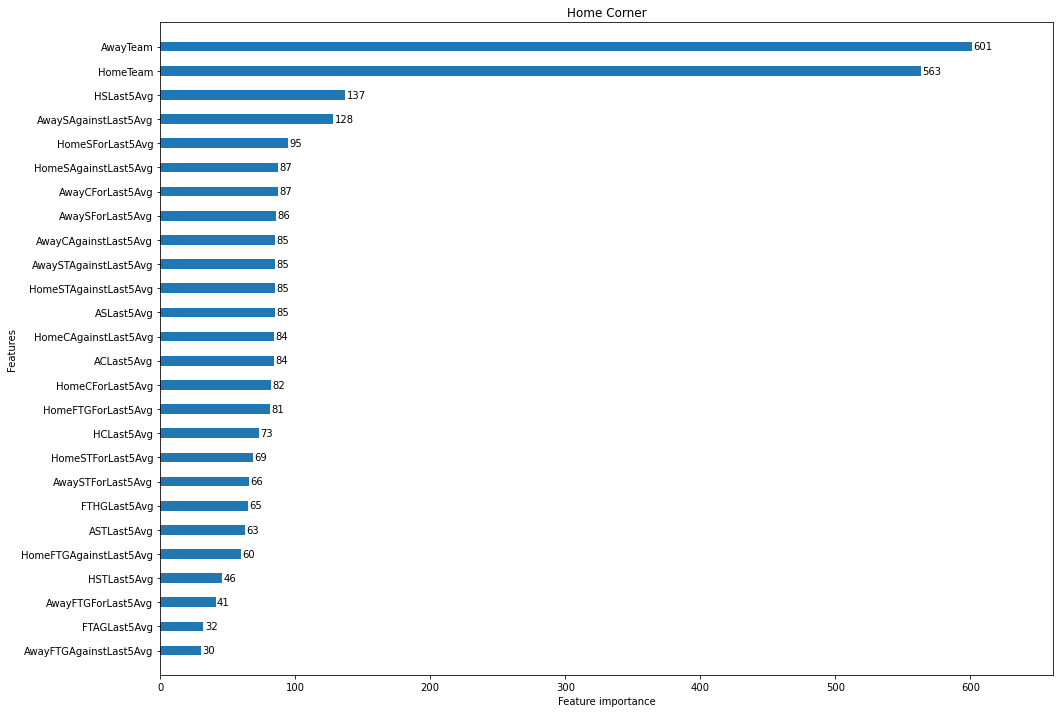

In [27]:
lgbm.plot_importance(m_lgbm.estimators_[0], figsize=(16, 12), title='Home Corner', max_num_features=40, height=0.4, grid=False);

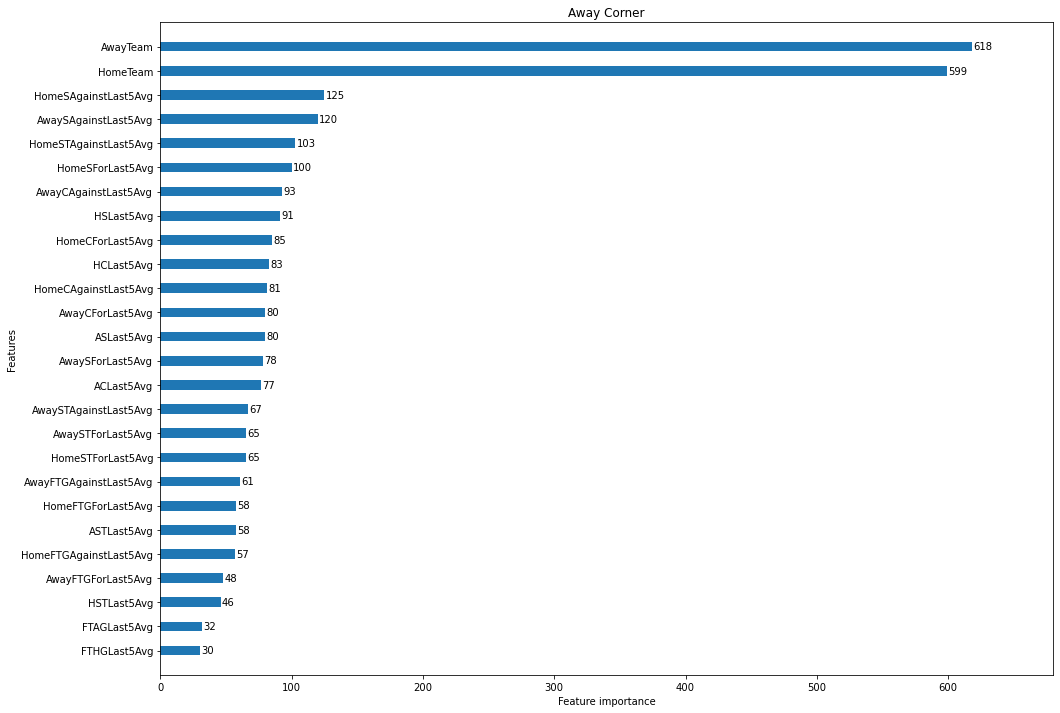

In [28]:
lgbm.plot_importance(m_lgbm.estimators_[1], figsize=(16, 12), title='Away Corner', max_num_features=40, height=0.4, grid=False);

## XGBoost

In [29]:
m_xgb = MultiOutputRegressor(XGBRegressor(objective='count:poisson', n_estimators=100, n_jobs=-1, tree_method='exact'))
m_xgb.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            objective='count:poisson',
                                            rand

In [30]:
import xgboost as xgb

In [31]:
for i in range(0, 2):
    m_xgb.estimators_[i].get_booster().feature_names = list(X_test.columns)

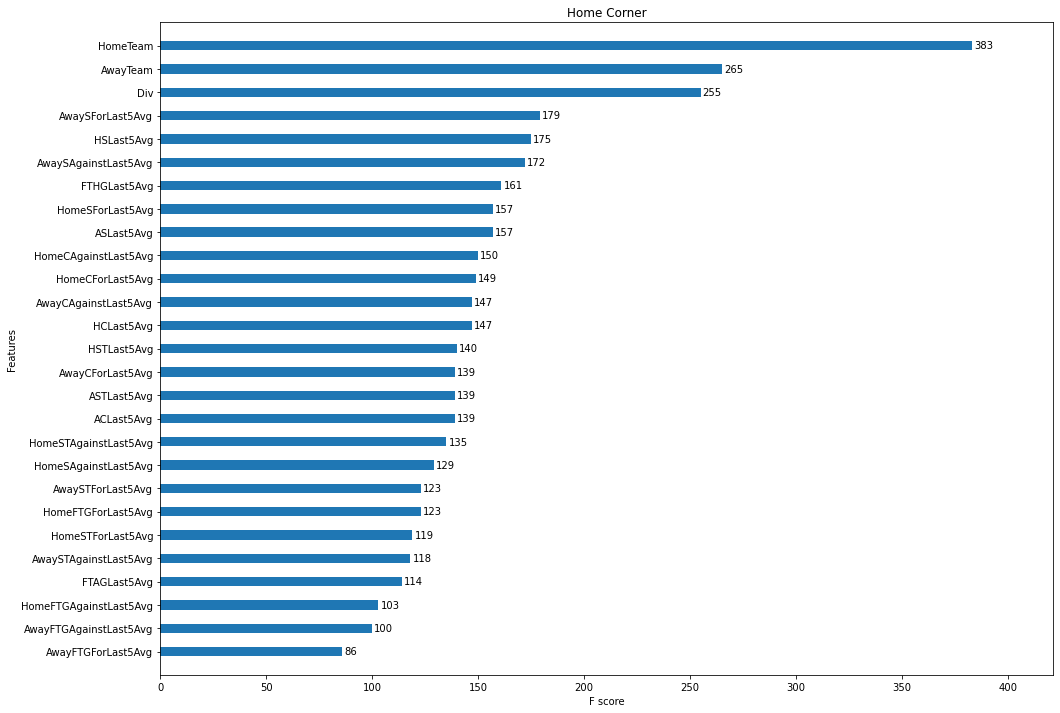

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[0], title='Home Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

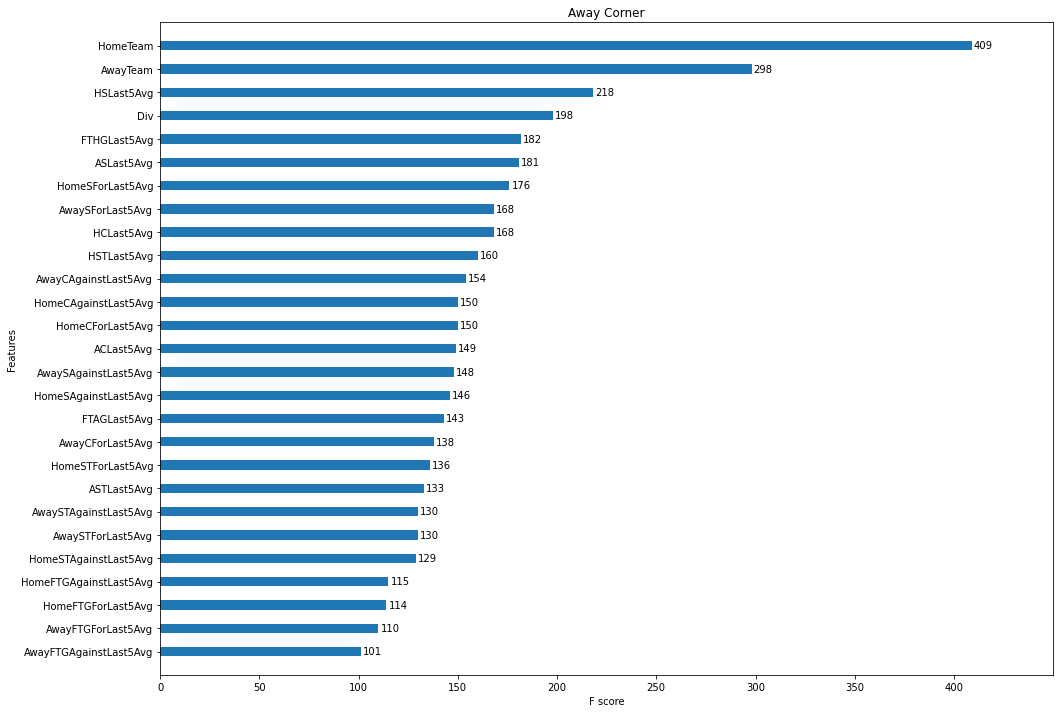

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[1], title='Away Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

## Poisson

In [34]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,HC,AC
0,F1,Bordeaux,Lens,0.8,9.8,3.0,4.4,1.8,11.6,3.6,5.4,0.6,9.8,3.4,3.6,1.6,11.0,4.0,4.0,2.8,12.600000,5.0,5.2,1.6,13.0,5.0,5.6,1.0,6.0
1,E0,Brighton,Man United,1.0,12.0,4.4,5.0,1.6,13.4,5.0,5.6,0.4,6.8,1.8,3.4,1.0,12.8,3.8,5.8,1.8,17.200001,6.0,5.6,0.6,9.6,3.2,3.2,3.0,5.0
2,I1,Torino,Empoli,1.4,13.4,6.2,5.0,1.4,10.8,6.4,7.8,0.6,10.0,5.0,4.2,2.0,9.6,5.6,6.2,0.6,8.000000,3.4,7.2,2.4,12.2,7.8,4.4,5.0,1.0
3,SP1,Ath Madrid,Celta,1.8,10.0,3.8,4.0,0.6,8.2,2.8,3.2,1.4,9.4,4.4,3.4,1.0,7.6,3.2,3.8,1.2,10.600000,3.6,5.0,1.6,13.8,4.8,5.4,13.0,3.0
4,I1,Brescia,Torino,1.0,10.2,4.0,5.6,1.0,6.8,4.0,4.0,0.8,6.2,3.2,5.2,0.2,8.0,4.6,5.0,1.8,11.000000,6.4,6.8,1.4,12.0,6.4,7.2,4.0,4.0
5,F1,Marseille,Montpellier,2.0,11.0,4.8,4.4,1.8,11.0,3.8,3.8,1.4,10.2,3.2,5.0,1.6,13.6,4.4,5.4,1.2,8.400000,2.4,3.6,2.4,12.4,5.8,4.2,5.0,1.0
6,E0,Southampton,Arsenal,1.2,10.0,4.0,4.8,1.2,13.0,4.2,4.8,0.2,7.0,2.8,3.8,2.2,15.6,6.4,6.0,0.6,12.400000,3.0,5.4,0.2,11.0,2.2,4.4,4.0,5.0
7,SP1,Eibar,Ath Bilbao,1.6,11.2,4.4,3.6,1.6,9.2,3.4,3.6,1.2,12.0,5.0,3.6,1.4,12.6,4.2,4.8,2.4,9.200000,5.2,3.6,1.0,9.6,2.6,4.6,8.0,3.0
8,I1,Parma,Sassuolo,1.8,10.4,4.8,3.2,1.6,13.6,5.6,5.6,1.2,9.8,3.2,3.6,1.4,14.2,6.4,4.8,2.8,14.400000,7.4,5.2,1.2,12.8,6.4,4.6,2.0,12.0
9,E0,Fulham,Leicester,0.4,10.2,3.6,3.2,1.6,15.0,4.0,6.0,0.8,11.8,4.4,2.2,1.6,14.0,5.6,6.2,1.2,14.400000,5.0,7.6,1.0,8.2,3.8,4.0,5.0,2.0


In [35]:
learn = tabular_learner(dls, layers=[240, 120])

In [36]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(130, 24)
    (2): Embedding(130, 24)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=76, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=2, bias=True)
    )
  )
)

In [37]:
learn.loss_func = BaseLoss(partial(nn.PoissonNLLLoss, log_input=True, full=True), floatify=True)

SuggestedLRs(valley=0.0020892962347716093)

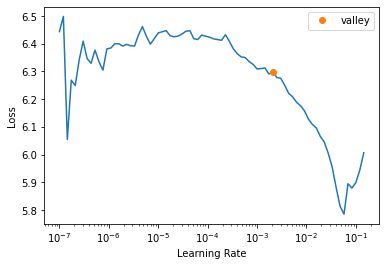

In [38]:
learn.lr_find()

In [39]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,3.976204,2.500691,00:00
1,2.690524,2.418786,00:00
2,2.447446,2.389572,00:00
3,2.336923,2.352685,00:00
4,2.268795,2.372920,00:00


In [40]:
df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,weight
2184,E0,Tottenham,Man City,1.0,0.0,13.0,18.0,3.0,4.0,3.0,...,6,227,False,False,False,False,False,False,1.628986e+09,2.536832


In [41]:
_, _, params = learn.predict(df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')
                               .drop(columns=y_names).iloc[0])

In [42]:
pois_corner_home = torch.distributions.poisson.Poisson(params[0].exp())
pois_corner_away = torch.distributions.poisson.Poisson(params[1].exp())

In [43]:
print(pois_corner_home.mean, pois_corner_home.variance)
print(pois_corner_away.mean, pois_corner_away.variance)

tensor(3.7933) tensor(3.7933)
tensor(6.3502) tensor(6.3502)


In [44]:
corner_home = pois_corner_home.log_prob(torch.arange(0., 15.)).exp()
corner_away = pois_corner_away.log_prob(torch.arange(0., 15.)).exp()
corner = torch.ger(corner_home, corner_away)
mask = torch.zeros_like(corner)

In [45]:
mask = torch.zeros_like(corner)
line = 10.5
for i in range(0, mask.size()[0]):
    for j in range(0, mask.size()[1]):
        if i + j < line: mask[i, j] = 1. 

In [46]:
prob_lo = (corner * mask).sum()
prob_hi = 1 - prob_lo

In [47]:
prob_lo, prob_hi

(tensor(0.5651), tensor(0.4349))

## Negative Binomial

In [39]:
y_names = ['HC', 'AC', 'weight']
y_block = RegressionBlock(n_out=5)

In [40]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [41]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,HC,AC,weight
0,I1,Sampdoria,Genoa,1.2,15.8,5.6,5.800000,0.6,10.0,3.2,4.0,0.8,10.0,4.2,3.8,1.0,12.000000,4.0,4.8,0.8,16.600000,4.2,9.4,1.8,16.0,6.4,7.0,4.0,4.0,0.929121
1,E0,West Brom,Wigan,1.2,11.4,5.0,6.200000,1.0,13.8,8.8,7.0,1.2,12.2,6.8,6.2,0.8,12.200000,7.2,6.6,1.2,12.800000,5.8,5.0,1.2,11.2,5.8,3.2,7.0,5.0,0.706460
2,I1,Cagliari,Milan,1.0,11.0,3.8,7.000000,1.4,7.8,4.0,3.8,1.0,9.6,4.2,5.4,2.8,12.800000,7.2,5.6,0.8,11.000000,3.8,7.0,1.4,13.6,5.2,3.2,3.0,8.0,1.151344
3,SP1,Osasuna,Villarreal,1.8,11.4,5.2,5.600000,0.2,9.2,3.6,3.0,1.2,7.0,2.8,2.8,0.6,11.600000,4.6,4.0,2.0,13.800000,5.8,7.8,0.8,11.8,2.8,4.8,7.0,3.0,0.623274
4,I1,Catania,Atalanta,1.8,13.6,6.4,5.600000,1.2,8.8,4.0,3.0,1.6,13.4,5.6,4.6,1.0,15.400000,4.2,4.6,1.6,16.799999,4.6,7.0,1.6,16.4,4.2,3.8,5.0,4.0,0.776396
5,F1,Montpellier,Valenciennes,1.8,14.0,5.0,6.800000,0.6,8.8,3.4,4.6,0.8,13.0,2.6,5.6,1.2,11.000000,3.6,4.4,0.8,10.600000,2.6,2.6,1.8,15.4,6.4,4.4,10.0,3.0,0.701550
6,SP1,Eibar,Sevilla,1.0,12.4,3.6,5.400000,2.6,16.0,5.6,6.2,0.8,10.2,1.8,4.0,1.8,15.600001,4.2,5.6,1.0,9.000000,4.4,5.4,1.0,15.0,5.4,5.0,6.0,3.0,1.155077
7,F1,Guingamp,Lorient,1.0,13.0,5.0,9.000000,0.2,8.4,3.2,3.0,0.5,9.0,3.5,6.5,1.2,10.800000,4.6,7.0,2.0,12.500000,4.0,4.5,1.4,9.8,4.0,4.8,6.0,5.0,0.726444
8,SP1,Barcelona,Malaga,2.6,21.0,6.8,9.399999,1.0,10.6,3.8,4.0,2.6,16.4,6.4,5.6,2.4,15.800000,5.2,6.0,1.4,8.800000,3.4,2.4,1.6,10.4,4.2,4.8,14.0,1.0,0.975360
9,E0,Wolves,Chelsea,2.0,15.2,9.8,6.400000,1.2,15.4,8.6,5.6,1.2,10.6,6.2,4.4,1.2,16.600000,8.4,6.4,2.0,16.799999,12.4,7.0,1.4,11.8,7.2,4.0,0.0,5.0,0.625607


In [42]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [43]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(169, 28)
    (2): Embedding(169, 28)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=84, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [44]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.010825139470398426)

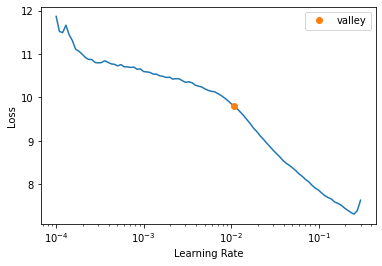

In [45]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=5e-01)

In [47]:
learn_bnb.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,4.591774,7.096431,00:02
1,4.571972,7.025170,00:02
2,4.574361,7.090791,00:02
3,4.534656,7.065159,00:02
4,4.492197,7.062470,00:02


In [48]:
df.query('Season==21 and HomeTeam=="Chelsea" and AwayTeam=="Man City"')[['HC', 'AC']]

,HC,AC
6982,4.0,13.0


In [49]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [50]:
_, params = learn_bnb.predict(df.query('Season==21 and HomeTeam=="Chelsea" and AwayTeam=="Man City"')
                                .drop(columns=y_names).iloc[0])

In [51]:
params

tensor([ -2.4008,  -2.9178,   3.9746,   6.1389, -43.0259])

In [52]:
alpha = F.softplus(params[0:2])
mu = F.softplus(params[2:4])
omega = params[4]
# omega = torch.tanh(params[4]) * 50.

total_count = 1. / alpha
logits = torch.log(alpha * mu)

print(alpha, mu, omega)

tensor([0.0868, 0.0526]) tensor([3.9932, 6.1411]) tensor(-43.0259)


In [53]:
bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)

In [54]:
print(bnb_corner.mean, bnb_corner.variance)

tensor([3.9932, 6.1411]) tensor([5.3769, 8.1263])


In [55]:
# Method 1:
corr = omega * torch.sqrt(mu.prod()) * alpha.prod() / ((1.+alpha)**(1./alpha+1.)).prod() / torch.sqrt((1.+alpha*mu).prod())
corr 

tensor(-0.0922)

In [56]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod()*(1.+alpha*mu).prod()) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod()
# corr 

In [57]:
value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [58]:
corner = bnb_corner.log_prob(value).exp()

In [59]:
line = 10.5
mask = value.sum(-1) < line
prob_lo = corner[mask].sum()
prob_hi = 1 - prob_lo

In [60]:
prob_lo, prob_hi

(tensor(0.5686), tensor(0.4314))

In [61]:
1/prob_lo, 1/prob_hi

(tensor(1.7586), tensor(2.3182))

### Train full model

In [62]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block)

In [63]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,HC,AC,weight
0,SP1,Levante,Ath Madrid,1.2,13.2,3.8,7.4,1.4,12.0,5.6,4.0,0.8,12.000000,2.2,6.0,1.60,13.20,6.0,5.20,1.6,10.4,3.4,4.4,0.60,10.800000,2.2,5.60,2.0,6.0,0.848592
1,D1,Hamburg,Hannover,1.6,18.0,7.6,6.0,0.4,13.0,3.8,4.8,2.8,16.200001,8.0,6.2,0.80,14.40,5.0,6.00,2.0,10.6,3.6,2.8,1.80,11.600000,4.4,5.00,7.0,3.0,0.743282
2,I1,Roma,Crotone,2.8,20.2,7.4,8.4,0.5,5.5,1.0,1.5,2.4,20.000000,7.2,6.2,0.75,8.25,1.5,1.75,1.2,12.4,4.6,5.0,1.75,15.750000,6.0,5.75,11.0,5.0,0.961132
3,F1,Rennes,Caen,1.8,15.0,4.0,5.6,1.0,9.0,2.8,2.6,1.2,13.200000,3.2,5.0,0.40,11.20,2.6,3.60,1.4,11.0,3.4,3.6,1.00,15.000000,4.6,6.40,5.0,4.0,1.202636
4,I1,Udinese,Fiorentina,0.8,12.0,3.2,5.8,1.4,10.4,3.4,3.8,0.4,11.000000,2.6,6.0,2.20,11.20,4.2,6.20,1.4,13.2,4.8,5.2,1.20,12.400000,3.2,4.40,6.0,6.0,0.743282
5,SP1,Barcelona,Granada,3.2,15.6,6.8,5.4,1.4,9.4,3.6,3.2,2.2,14.000000,5.4,6.0,1.00,11.40,3.0,4.40,0.6,9.6,2.8,3.0,2.00,9.800000,4.8,5.20,7.0,0.0,0.901762
6,SP1,Valencia,Sp Gijon,1.6,11.0,4.4,3.4,0.4,8.0,1.4,5.2,1.0,10.000000,3.4,5.8,1.40,11.00,3.0,6.00,1.6,15.6,4.8,6.4,2.40,12.000000,4.8,3.20,6.0,3.0,0.906717
7,I1,Lazio,Cagliari,1.6,16.4,5.8,8.8,1.0,8.2,3.6,3.8,1.6,17.200001,5.4,9.2,1.80,9.20,4.6,3.80,1.0,13.2,4.4,3.6,2.40,20.200001,7.0,10.00,4.0,10.0,0.969547
8,SP1,Villarreal,Ath Bilbao,1.6,12.4,4.2,3.8,1.0,11.6,3.6,6.8,1.2,11.000000,2.8,4.4,1.20,9.60,2.8,5.40,0.8,6.8,2.2,2.4,1.60,10.400000,3.0,3.80,6.0,4.0,1.415038
9,E0,Southampton,Everton,2.6,16.6,5.0,7.2,1.4,12.0,5.2,5.2,1.8,13.400000,5.0,5.0,1.20,14.20,4.0,7.40,1.8,11.0,4.6,4.4,1.80,12.200000,3.6,4.00,9.0,9.0,0.869344


In [64]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [65]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(169, 28)
    (2): Embedding(169, 28)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=84, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [66]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.013976634480059147)

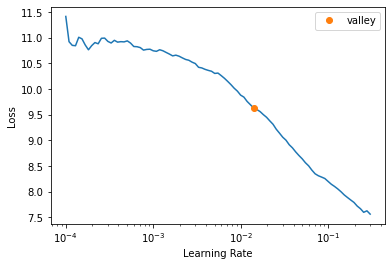

In [67]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=5e-01)

In [68]:
learn_bnb.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,4.868276,None,00:02
1,4.754701,None,00:02
2,4.747594,None,00:02
3,4.681550,None,00:02
4,4.652977,None,00:02


/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [69]:
learn_bnb.export('models/learn_bnbsl.pkl')

In [70]:
to.export('models/to.pkl')

### t-SNE

In [79]:
df['HomeTeam'].astype('category').cat.categories.values

array(['Alaves', 'Amiens', 'Angers', 'Arsenal', 'Aston Villa', 'Atalanta',
       'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Barcelona',
       'Bayern Munich', 'Benevento', 'Betis', 'Bielefeld', 'Bochum',
       'Bologna', 'Bordeaux', 'Bournemouth', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Burnley', 'Cadiz', 'Caen', 'Cagliari',
       'Cardiff', 'Celta', 'Chelsea', 'Chievo', 'Clermont', 'Crotone',
       'Crystal Palace', 'Dijon', 'Dortmund', 'Eibar', 'Ein Frankfurt',
       'Elche', 'Empoli', 'Espanol', 'Everton', 'FC Koln', 'Fiorentina',
       'Fortuna Dusseldorf', 'Freiburg', 'Frosinone', 'Fulham', 'Genoa',
       'Getafe', 'Girona', 'Granada', 'Greuther Furth', 'Guingamp',
       'Hannover', 'Hertha', 'Hoffenheim', 'Huddersfield', 'Huesca',
       'Inter', 'Juventus', 'Lazio', 'Lecce', 'Leeds', 'Leganes',
       'Leicester', 'Lens', 'Levante', 'Leverkusen', 'Lille', 'Liverpool',
       'Lorient', 'Lyon', "M'gladbach", 'Mainz', 'Mallorca', 'Man City',
       'Man United'

In [80]:
df['AwayTeam'].astype('category').cat.categories.values

array(['Alaves', 'Amiens', 'Angers', 'Arsenal', 'Aston Villa', 'Atalanta',
       'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Barcelona',
       'Bayern Munich', 'Benevento', 'Betis', 'Bielefeld', 'Bochum',
       'Bologna', 'Bordeaux', 'Bournemouth', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Burnley', 'Cadiz', 'Caen', 'Cagliari',
       'Cardiff', 'Celta', 'Chelsea', 'Chievo', 'Clermont', 'Crotone',
       'Crystal Palace', 'Dijon', 'Dortmund', 'Eibar', 'Ein Frankfurt',
       'Elche', 'Empoli', 'Espanol', 'Everton', 'FC Koln', 'Fiorentina',
       'Fortuna Dusseldorf', 'Freiburg', 'Frosinone', 'Fulham', 'Genoa',
       'Getafe', 'Girona', 'Granada', 'Greuther Furth', 'Guingamp',
       'Hannover', 'Hertha', 'Hoffenheim', 'Huddersfield', 'Huesca',
       'Inter', 'Juventus', 'Lazio', 'Lecce', 'Leeds', 'Leganes',
       'Leicester', 'Lens', 'Levante', 'Leverkusen', 'Lille', 'Liverpool',
       'Lorient', 'Lyon', "M'gladbach", 'Mainz', 'Mallorca', 'Man City',
       'Man United'

In [81]:
variable = 'HomeTeam'
ix = cat_names.index(variable)

var_vals = list(df[variable].astype('category').cat.categories.values)
nval = len(var_vals)
print(f'Number of values: {nval}')
print(var_vals)

Number of values: 129
['Alaves', 'Amiens', 'Angers', 'Arsenal', 'Aston Villa', 'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Barcelona', 'Bayern Munich', 'Benevento', 'Betis', 'Bielefeld', 'Bochum', 'Bologna', 'Bordeaux', 'Bournemouth', 'Brentford', 'Brescia', 'Brest', 'Brighton', 'Burnley', 'Cadiz', 'Caen', 'Cagliari', 'Cardiff', 'Celta', 'Chelsea', 'Chievo', 'Clermont', 'Crotone', 'Crystal Palace', 'Dijon', 'Dortmund', 'Eibar', 'Ein Frankfurt', 'Elche', 'Empoli', 'Espanol', 'Everton', 'FC Koln', 'Fiorentina', 'Fortuna Dusseldorf', 'Freiburg', 'Frosinone', 'Fulham', 'Genoa', 'Getafe', 'Girona', 'Granada', 'Greuther Furth', 'Guingamp', 'Hannover', 'Hertha', 'Hoffenheim', 'Huddersfield', 'Huesca', 'Inter', 'Juventus', 'Lazio', 'Lecce', 'Leeds', 'Leganes', 'Leicester', 'Lens', 'Levante', 'Leverkusen', 'Lille', 'Liverpool', 'Lorient', 'Lyon', "M'gladbach", 'Mainz', 'Mallorca', 'Man City', 'Man United', 'Marseille', 'Metz', 'Milan', 'Monaco', 'Montpellier', 'Nantes', 'Napoli', 'Newc

In [82]:
# import altair as alt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

emb_mx = to_np(next(learn_bnb.model.embeds[ix].parameters()))
#X_emb = TSNE(n_components=2, perplexity=3).fit_transform(emb_mx)
#X_emb = PCA(n_components=2).fit_transform(emb_mx)
annotation = np.append('Other', np.array(var_vals))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' 

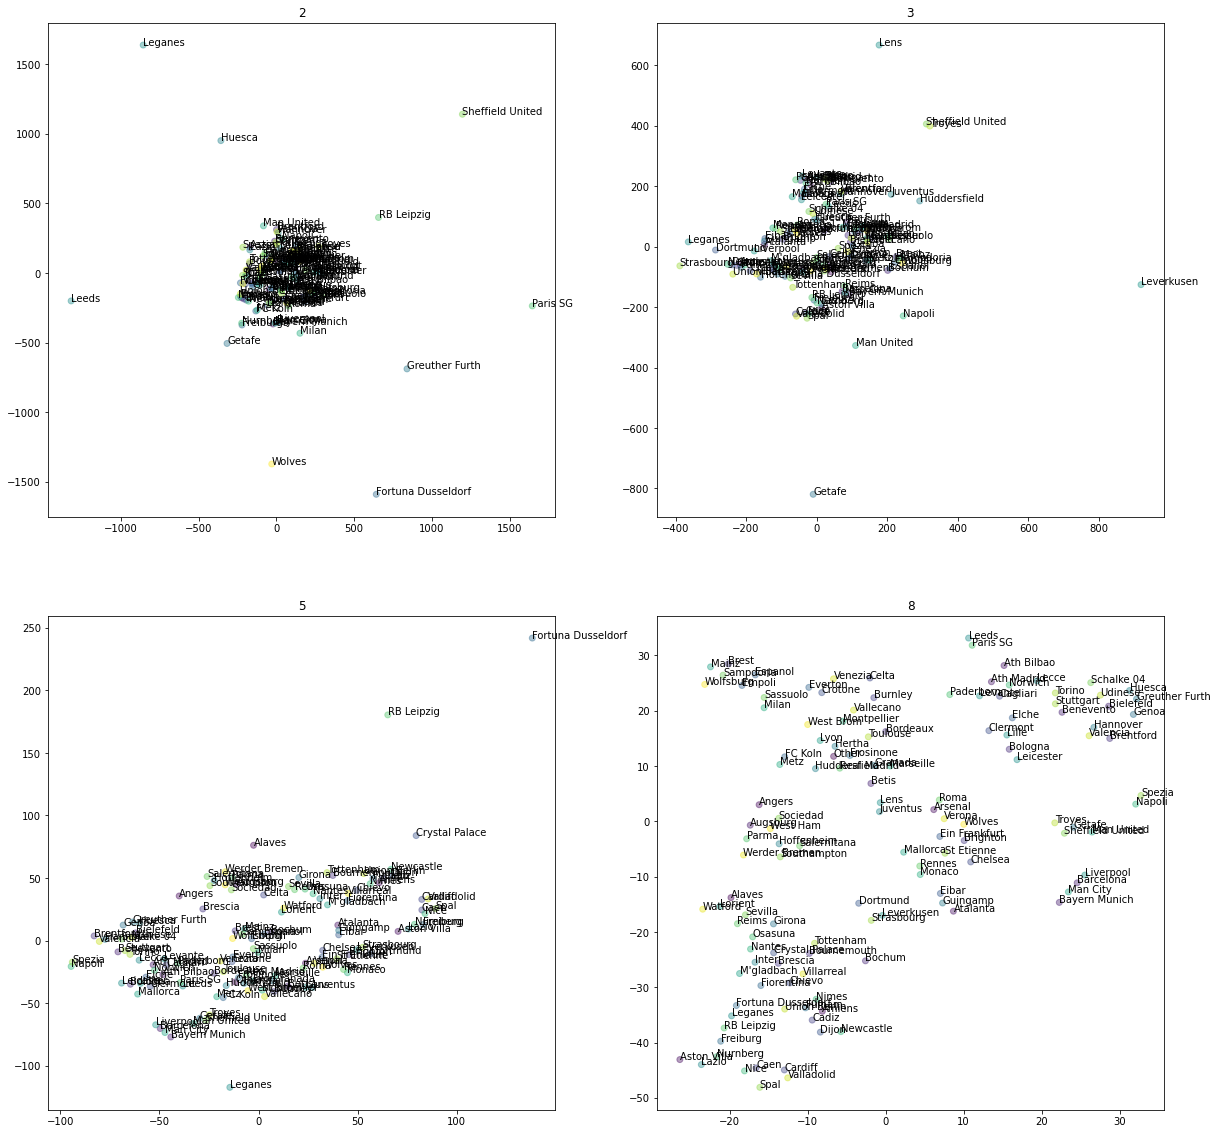

In [83]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(20)
fig.set_figwidth(20)

perplexity = [2, 3, 5, 8]
for ax,perp in zip(axes.flatten(), perplexity):
    X_emb = TSNE(n_components=2, perplexity=perp).fit_transform(emb_mx)
    ax.scatter(X_emb[:,0], X_emb[:,1], c=range(len(annotation)), alpha=0.4)
    for xy,target in zip(X_emb, annotation):
        if isinstance(target, np.str_) or isinstance(target, str):
            text = target
        else:
            text = "%d" % target
        ax.annotate(text=text, xy=(xy[0], xy[1]))
        ax.set_title(perp)

# END